In [297]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [298]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [324]:
# Read file to pd dataframe
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
# Get rid of "id" and "product_code"
train = train.iloc[:train.shape[0], 2:train.shape[1]]
test = test.iloc[:test.shape[0], 2:test.shape[1]]
# Shuffle the training data
train = train.reindex(np.random.permutation(train.index))

In [325]:
# Map the value in attribute_0 and attribute_1
attribute_0 = {"material_5": "0", "material_7": "1"}
attribute_1 = {"material_5": "0", "material_6": "1",
               "material_7": "2", "material_8": "3"}
# Replace the value in attribute_0 and attribute_1
train = train.replace({"attribute_0": attribute_0})
train = train.replace({"attribute_1": attribute_1})
test = test.replace({"attribute_0": attribute_0})
test = test.replace({"attribute_1": attribute_1})
# Change the column type from obejct to int
train["attribute_0"] = train["attribute_0"].astype(int)
train["attribute_1"] = train["attribute_1"].astype(int)
test["attribute_0"] = test["attribute_0"].astype(int)
test["attribute_1"] = test["attribute_1"].astype(int)

In [326]:
'''
# Add two new feature indicating whether m3 and m5 is missing base on reference from discussion
train["missing_measure_3"] = train["measurement_3"].isna()
train["missing_measure_5"] = train["measurement_5"].isna()
test["missing_measure_3"] = test["measurement_3"].isna()
test["missing_measure_5"] = test["measurement_5"].isna()'''
# Fill the Nan value with the average
for i in train.columns:
    null_cols=train[train[i].isna()].index
    for n in null_cols:
        train.loc[n,i]=train[i].mean()
for i in test.columns:
    null_cols = test[test[i].isna()].index
    for n in null_cols:
        test.loc[n,i]=test[i].mean()

In [302]:
# Apply feature engineering from reference in discussion
# Multiply length dimensions to get area. attributes 2 and 3 look like they are width and length dimensions or similar.
# Aggregate measurement_3 to 16 into average and stdev. They look like they belong to the same group.
'''def mean_3_to_16(row):
    return row.iloc[10:20].mean()

def std_3_to_16(row):
    return row.iloc[10:20].std()

def attri_multi(row):
    return row.iloc[3] * row.iloc[4]

train["measurement_std"] = train.apply(lambda row : std_3_to_16(row), axis = 1)
train['measurement_mean'] = train.apply(lambda row : mean_3_to_16(row), axis = 1)
train['attri_2_attri_3'] = train.apply(lambda row : attri_multi(row), axis = 1)
remain_col = ["loading", "attribute_0", "attribute_1", "attri_2_attri_3", "measurement_0",
              "measurement_1", "measurement_2", "measurement_3", "measurement_17", "measurement_mean", "measurement_std", "missing_measure_3", "missing_measure_3", "failure"]
train = train[remain_col]

test["measurement_std"] = test.apply(lambda row: std_3_to_16(row), axis=1)
test['measurement_mean'] = test.apply(lambda row: mean_3_to_16(row), axis=1)
test['attri_2_attri_3'] = test.apply(lambda row: attri_multi(row), axis=1)
remain_col = ["loading", "attribute_0", "attribute_1", "attri_2_attri_3", "measurement_0",
              "measurement_1", "measurement_2", "measurement_3", "measurement_17", "measurement_mean", "measurement_std", "missing_measure_3", "missing_measure_3"]
test =test[remain_col]'''

In [327]:
train.head()

,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
6561,132.51,0,0,8,8,5,9,4,18.634,11.986,...,10.739,18.933,20.515,12.786,15.381,16.048444,14.310000,17.184,701.269059,0
15158,113.47,1,3,5,8,2,19,11,17.489,11.527,...,11.056,16.724,19.680,14.445,15.914,18.462000,17.144000,17.291,774.651000,1
26041,161.52,1,1,6,9,6,7,3,20.264,10.108,...,8.301,15.231,19.301,10.746,15.177,16.644000,14.995554,13.472,366.744000,1
22016,125.63,1,1,6,9,8,9,3,17.612,11.343,...,11.897,16.089,22.296,15.490,15.171,14.771000,16.503000,17.744,252.404000,0
14482,173.44,1,3,5,8,10,10,4,16.846,11.145,...,12.260,16.463,18.060,11.526,15.707,18.026000,17.020000,19.019,701.269059,0


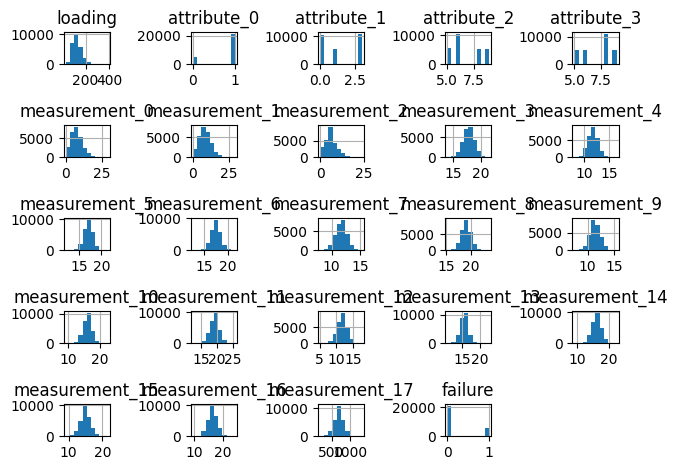

In [328]:
_ = train.hist()
plt.tight_layout()

In [329]:
# Split the feature and target, also into training data and validation data
train_size = 0.9
x_train = train.iloc[:int(train.shape[0] *train_size), :train.shape[1] - 1].values
y_train = train.iloc[:int(train.shape[0] *train_size), train.shape[1] - 1:].values
x_valid = train.iloc[int(train.shape[0] * train_size):, :train.shape[1] - 1].values
y_valid = train.iloc[int(train.shape[0] * train_size):, train.shape[1] - 1:].values

In [330]:
x_train = x_train.tolist()
y_train = y_train.tolist()
x_valid = x_valid.tolist()
y_valid = y_valid.tolist()

In [331]:
def encode_single_sample(features, label):
    features = np.reshape(features, (23,))
    return {"features": features, "label": label}

batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [332]:
def build_model():
    model = keras.models.Sequential()
    model.add(layers.Flatten(input_shape=(23,)),)
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(250, activation='relu'))
    model.add(layers.Dense(125, activation='relu'))
    model.add(layers.Dense(62, activation='relu'))     
    model.add(layers.Dense(1, activation='sigmoid'))
    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 23)                0         
                                                                 
 dense_135 (Dense)           (None, 500)               12000     
                                                                 
 dropout_27 (Dropout)        (None, 500)               0         
                                                                 
 dense_136 (Dense)           (None, 250)               125250    
                                                                 
 dense_137 (Dense)           (None, 125)               31375     
                                                                 
 dense_138 (Dense)           (None, 62)                7812      
                                                                 
 dense_139 (Dense)           (None, 1)               

In [333]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
748/748 [==============================] - 3s 3ms/step - loss: 0.7066 - accuracy: 0.7566 - val_loss: 0.5198 - val_accuracy: 0.7892
Epoch 2/100
748/748 [==============================] - 2s 3ms/step - loss: 0.5369 - accuracy: 0.7846 - val_loss: 0.5173 - val_accuracy: 0.7892
Epoch 3/100
748/748 [==============================] - 2s 3ms/step - loss: 0.5245 - accuracy: 0.7871 - val_loss: 0.5117 - val_accuracy: 0.7892
Epoch 4/100
748/748 [==============================] - 2s 3ms/step - loss: 0.5180 - accuracy: 0.7869 - val_loss: 0.5121 - val_accuracy: 0.7892
Epoch 5/100
748/748 [==============================] - 2s 3ms/step - loss: 0.5157 - accuracy: 0.7871 - val_loss: 0.5102 - val_accuracy: 0.7892
Epoch 6/100
748/748 [==============================] - 2s 3ms/step - loss: 0.5153 - accuracy: 0.7867 - val_loss: 0.5119 - val_accuracy: 0.7892
Epoch 7/100
748/748 [==============================] - 2s 3ms/step - loss: 0.5159 - accuracy: 0.7862 - val_loss: 0.5177 - val_accuracy: 0.7892

In [334]:
y_pred = model.predict(test.values.tolist())
y_pred = np.array(y_pred)
y_pred = pd.DataFrame(y_pred, columns= ["failure"])
submission = pd.read_csv("data/sample_submission.csv")
sub = pd.DataFrame({'id': submission.id, 'failure': y_pred.failure})
print(sub)
sub.to_csv("submission.csv", index=False)


650/650 [==============================] - 1s 928us/step
          id   failure
0      26570  0.210089
1      26571  0.193241
2      26572  0.201705
3      26573  0.204351
4      26574  0.280895
...      ...       ...
20770  47340  0.235322
20771  47341  0.161488
20772  47342  0.156382
20773  47343  0.213878
20774  47344  0.166177

[20775 rows x 2 columns]


In [335]:
model.save_weights("model.h5")